# Objective
Predict the price of a house

In [326]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing

# Data preparation

In [327]:
housing = fetch_california_housing()
print(housing.data.shape, housing.target.shape)

(20640, 8) (20640,)


## Dataset description

In [328]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [329]:
data, target = fetch_california_housing(as_frame=True, return_X_y=True)
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [330]:
target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

# EDA

No empty record

In [331]:
data.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

- All columns are numeric, no need to handle categorical variables
- Need to figure out how best to use the coordinates

In [332]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


## Target variable (MedHouseVal) 
- A normal distribution thats skewed to the right/positive skewness. There are outlier values at the furthest right
- Need to normalize or scale the data
- **Skewness** focuses on the spread (tails) of normal distribution
- **Kurtosis** focuses more on the height. It tells us how peaked or flat our normal (or normal-like) distribution is

[Skewness and kurtosis](https://www.datacamp.com/tutorial/understanding-skewness-and-kurtosis)

<Axes: xlabel='MedHouseVal', ylabel='Count'>

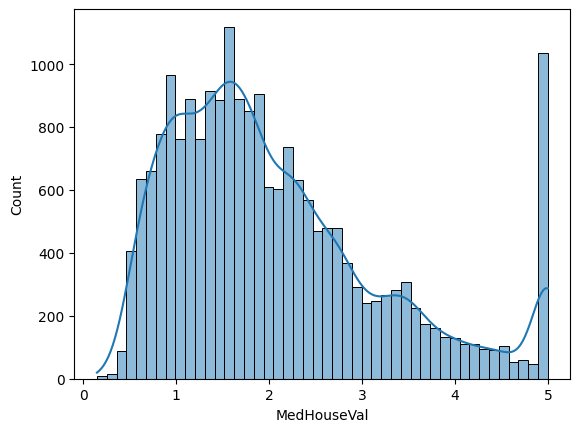

In [333]:
sns.histplot(target, kde=True)

<Axes: xlabel='MedHouseVal', ylabel='Count'>

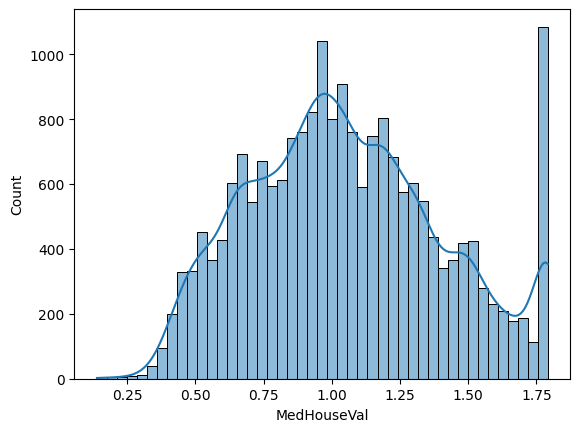

In [334]:
sns.histplot(np.log1p(target), kde=True) # log normalizes distribution

### Skewness and kurtosis

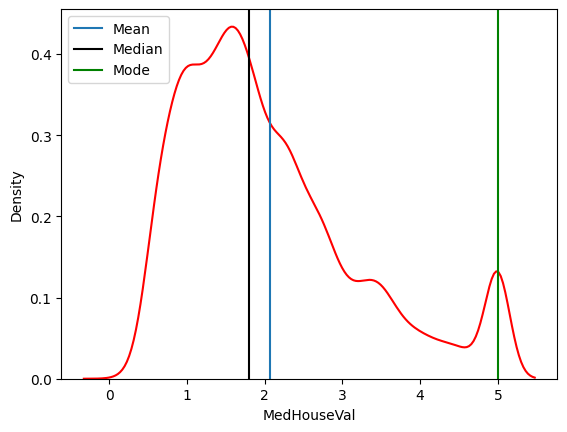

In [335]:
sns.kdeplot(target, color='red') # better than histogram as you don't have to worry about bin size, less noisy
plt.axvline(target.mean(), label="Mean")
plt.axvline(target.median(), color="black", label="Median")
plt.axvline(target.mode().values[0], color="green", label="Mode")
plt.legend()

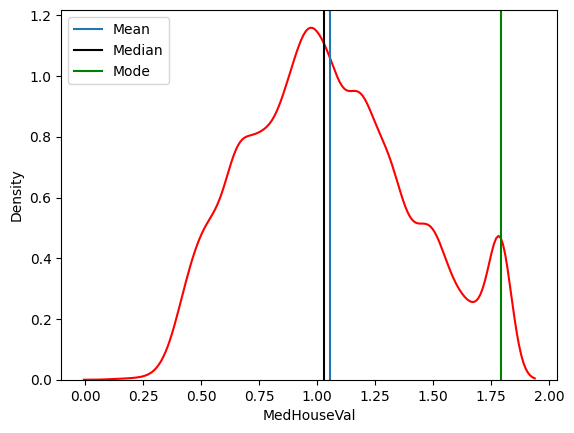

In [336]:
sns.kdeplot(np.log1p(target), color='red') # better than histogram as you don't have to worry about bin size, less noisy
plt.axvline(np.log1p(target).mean(), label="Mean")
plt.axvline(np.log1p(target).median(), color="black", label="Median")
plt.axvline(np.log1p(target).mode().values[0], color="green", label="Mode")
plt.legend()

- Median > mean and mode > greater than both
- It visually looks like its skewed to the right but we need to handle that outlier

In [337]:
print(f"Mean: {target.mean()}\nMedian: {target.median()}\nMode: {target.mode().values[0]}")

Mean: 2.068558169089147
Median: 1.797
Mode: 5.00001


In [338]:
print(f"Skewness is: {round(target.skew(), 1)} - highly skewed (positive)")

Skewness is: 1.0 - highly skewed (positive)


In [339]:
print(f"Kurtosis is: {round(target.kurtosis(), 1)} - platykurtic") # flat peak, light tails

Kurtosis is: 0.3 - platykurtic


# Predictor variables

In [340]:
data.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

### Skewness and kurtosis

- 'AveRooms', 'AveBedrms', 'Population' and 'AveOccup' are positively skewed with high kurtosis (sharp peak)
- 'MedInc' is also positively skewed with high kurtosis but it isn't as sharp as the rest
- Hard to explain the distribution of 'HouseAge'

In [341]:
predictor_df = data[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']]
predictor_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467


In [342]:
predictor_df.skew()

MedInc         1.646657
HouseAge       0.060331
AveRooms      20.697869
AveBedrms     31.316956
Population     4.935858
AveOccup      97.639561
dtype: float64

In [343]:
predictor_df.kurtosis()

MedInc            4.952524
HouseAge         -0.800629
AveRooms        879.353264
AveBedrms      1636.711972
Population       73.553116
AveOccup      10651.010636
dtype: float64

### Univariate analysis

In [344]:
combined_df = pd.concat([data, target], axis=1)
combined_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


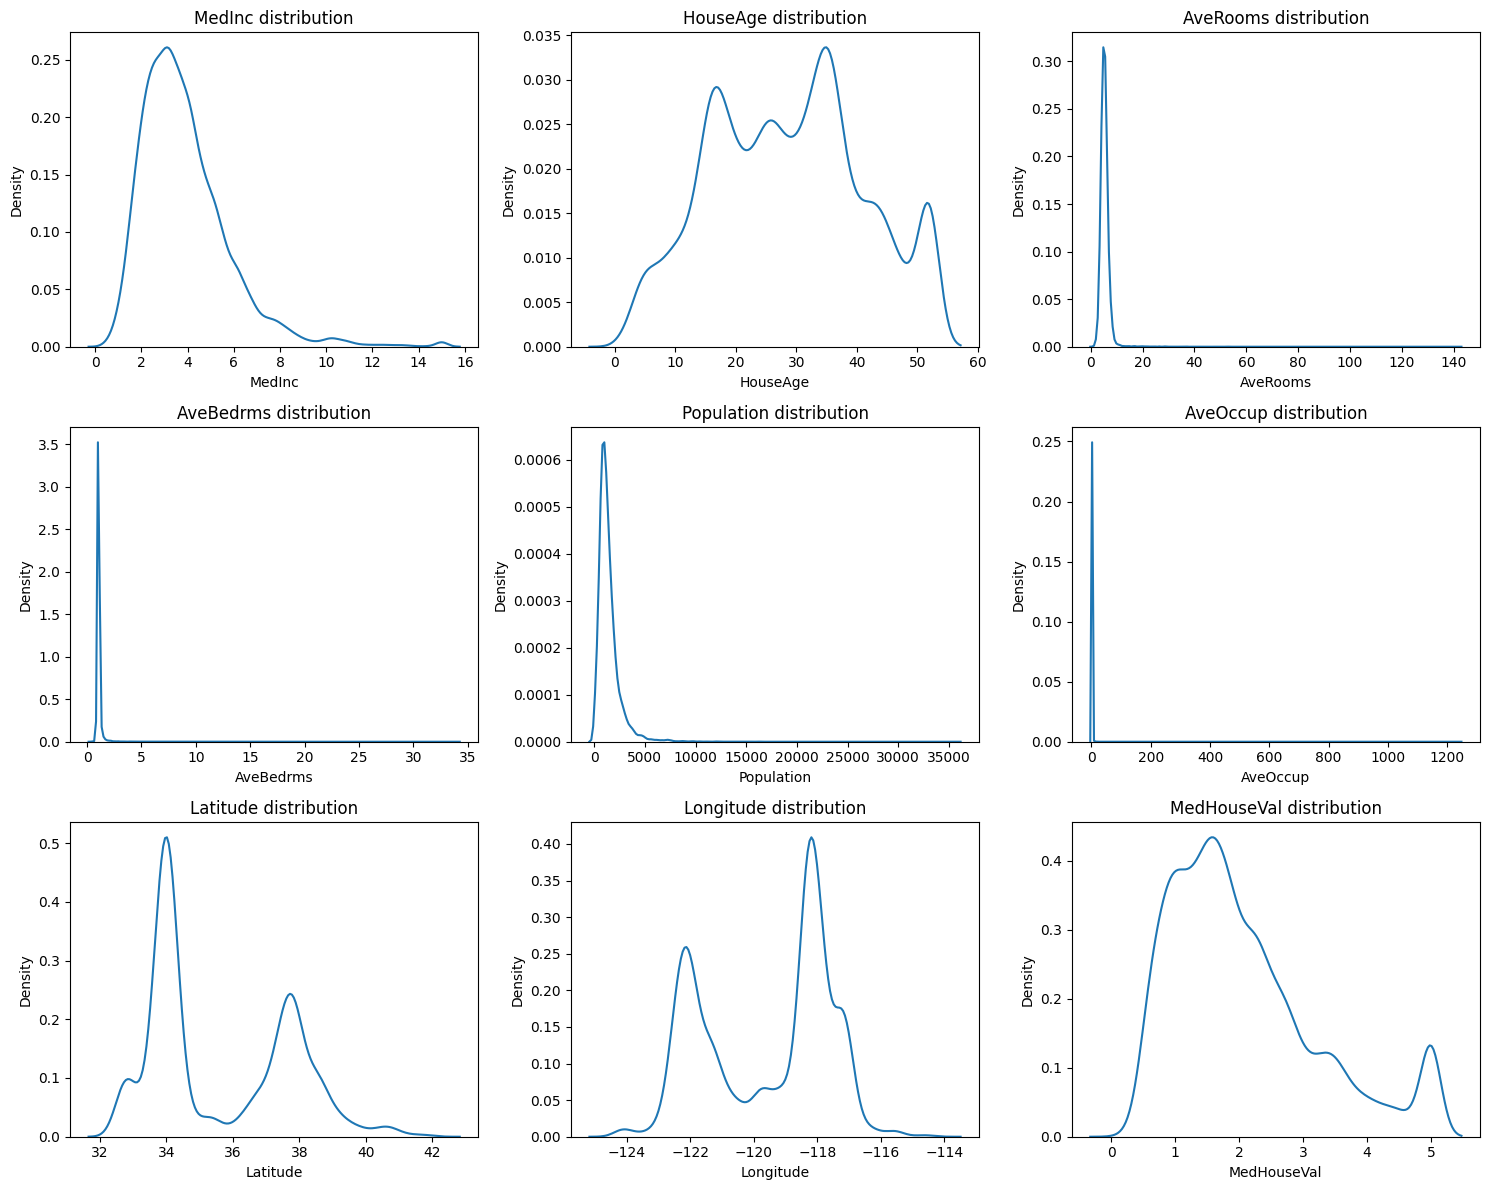

In [345]:
fix, ax = plt.subplots(3, 3, figsize=(15, 12))

for i, col in enumerate(combined_df.columns):
    sns.kdeplot(combined_df[col], ax=ax[i//3, i%3])
    ax[i//3, i%3].set_title(f"{col} distribution")
plt.tight_layout()

# Normalizing the data improves most of the dstributions except the coordinates

/Users/sheilambadi/Documents/Professional growth/Data Science/machine-learning-zoomcamp/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log1p

/var/folders/pp/007n2p8s51q_lcqhzv__fw_c0000gn/T/ipykernel_73913/710676647.py:4: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



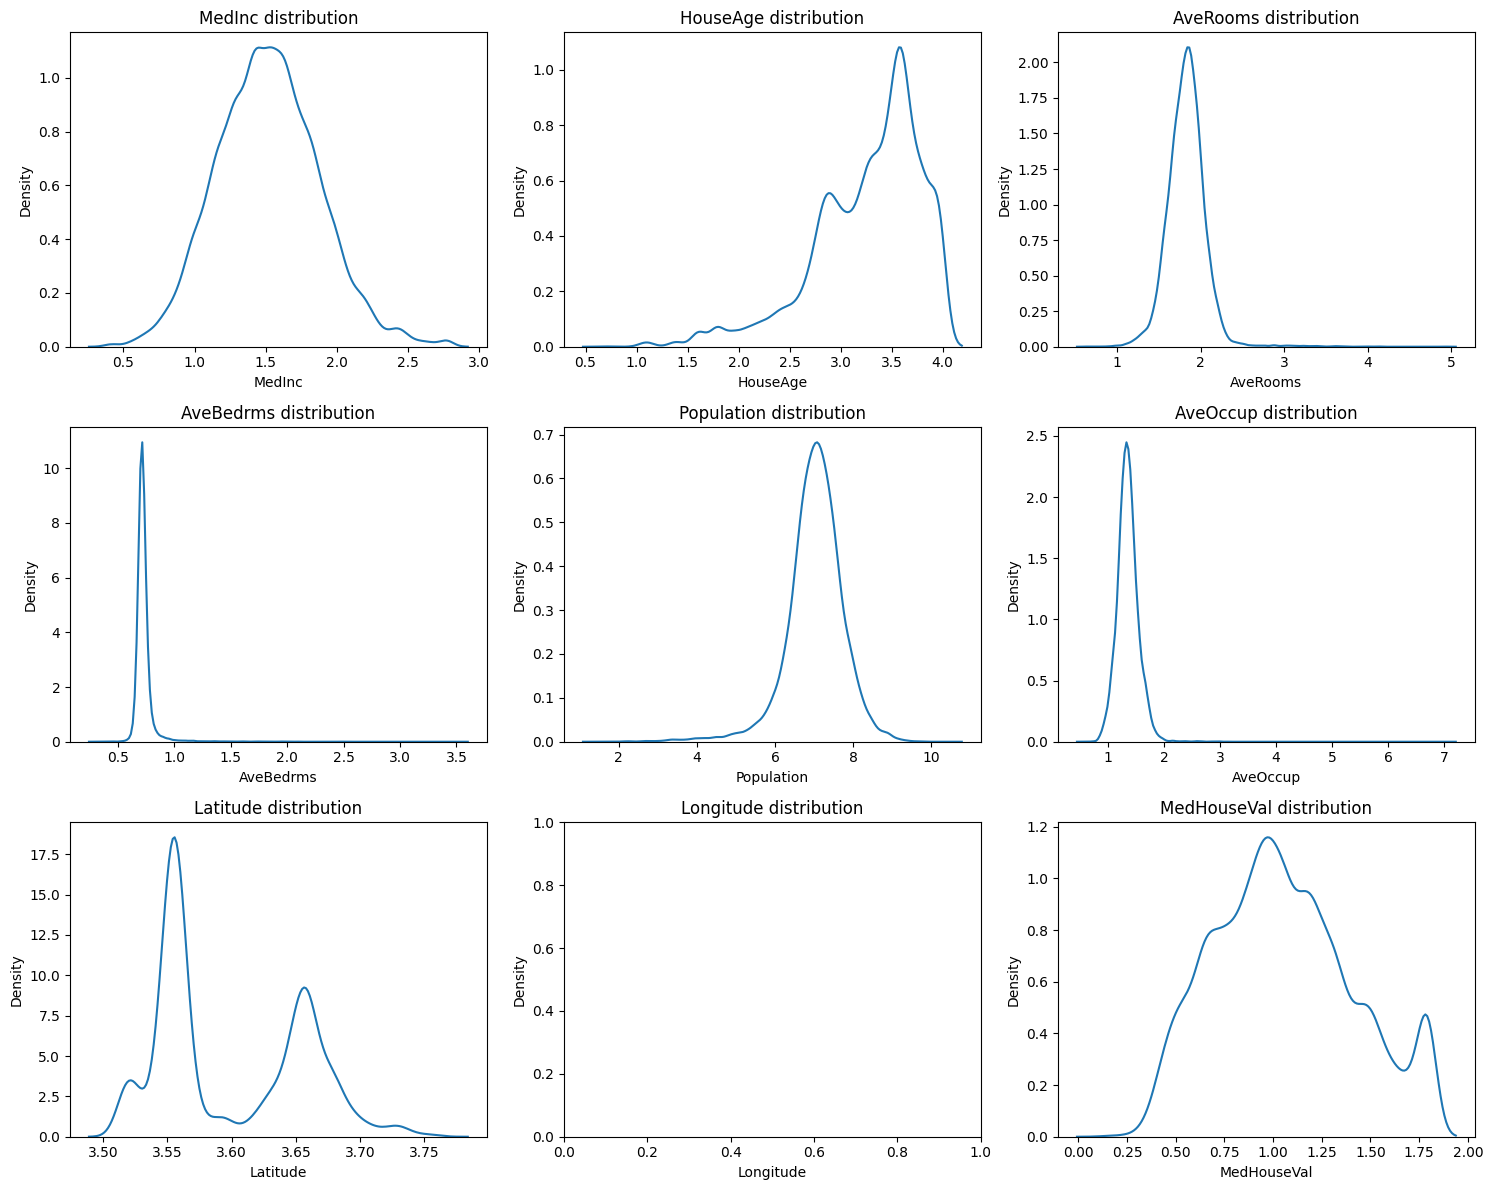

In [376]:
fix, ax = plt.subplots(3, 3, figsize=(15, 12))

for i, col in enumerate(combined_df.columns):
    sns.kdeplot(np.log1p(combined_df[col]), ax=ax[i//3, i%3])
    ax[i//3, i%3].set_title(f"{col} distribution")
plt.tight_layout()

Attribute Information:

    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

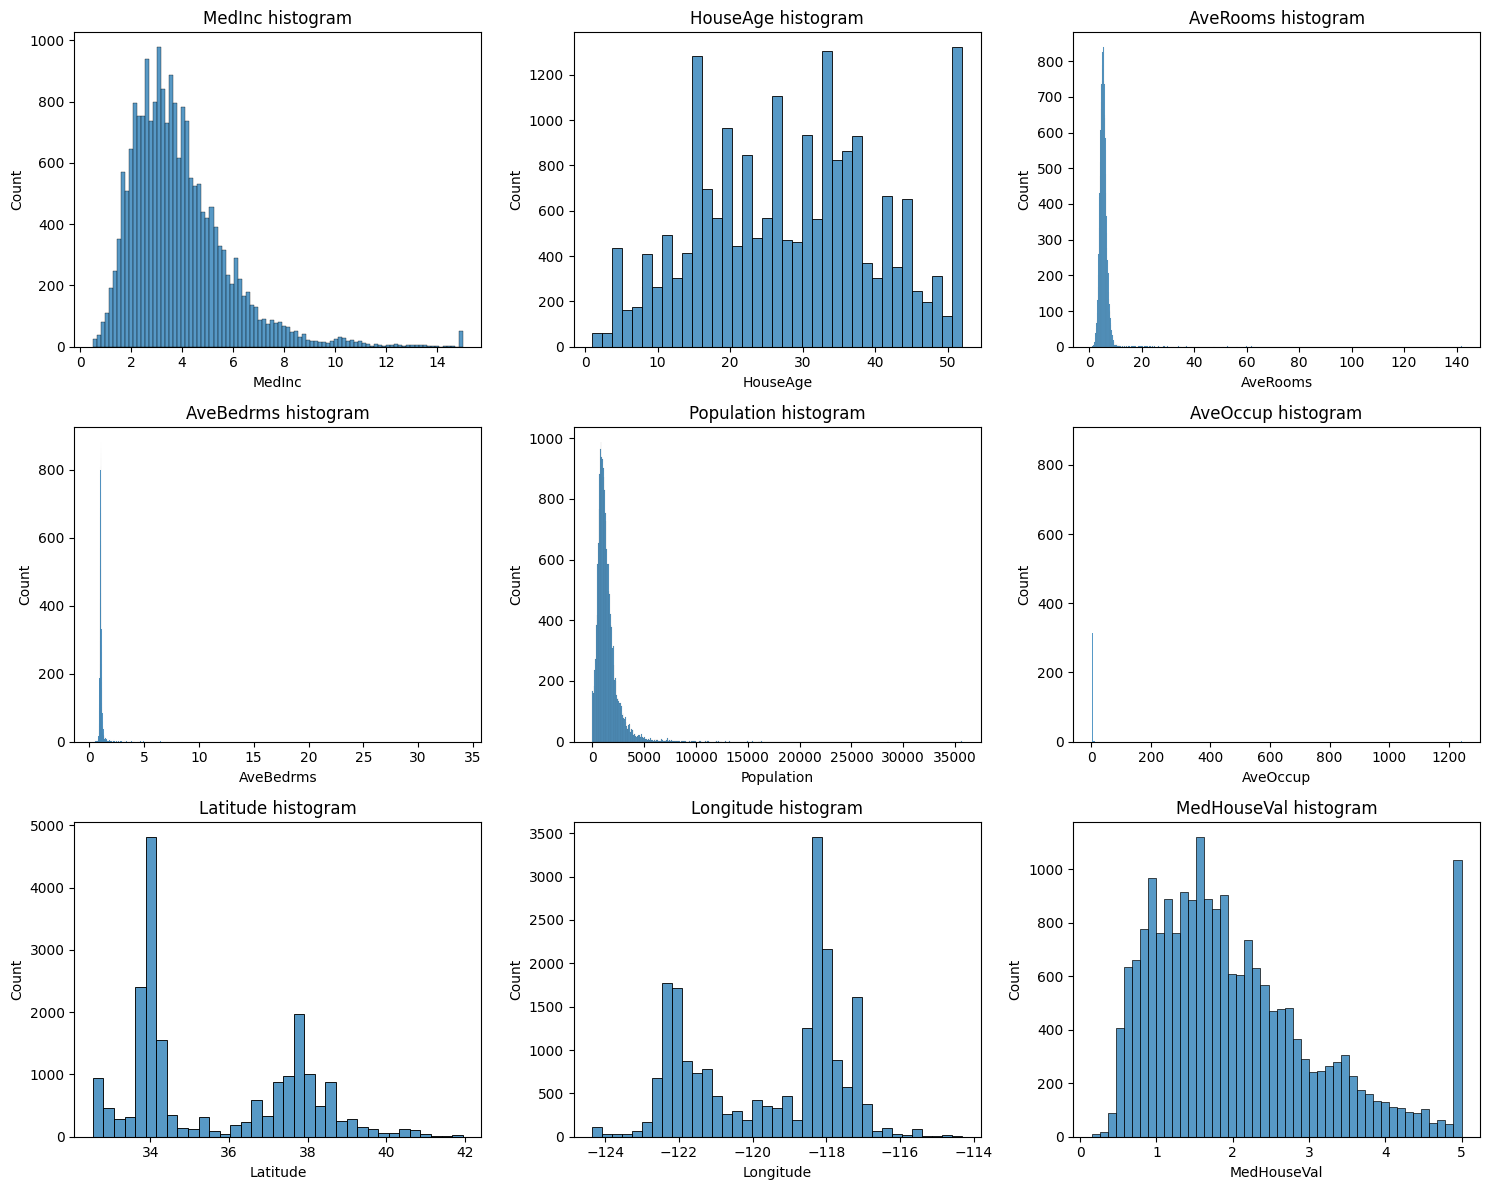

In [346]:
fix, ax = plt.subplots(3, 3, figsize=(15, 12))

for i, col in enumerate(combined_df.columns):
    sns.histplot(combined_df[col], ax=ax[i//3, i%3])
    ax[i//3, i%3].set_title(f"{col} histogram")

plt.tight_layout()

## Visualize coordinates
- Houses closer to the beach are more expensive

In [347]:
px.scatter_geo(data_frame=data, 
               lat=data.Latitude, 
               lon=data.Longitude, 
               color=target,
               scope='usa', 
               fitbounds='locations', 
               title='California Housing Prices')

In [405]:
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


[Medium tutorial](https://medium.com/@basumatary18/implementing-linear-regression-on-california-housing-dataset-378e14e421b7)

The plot below displays the map of California, with the color map corresponding to house value and the radius of the circles corresponding to the population of the areas. Based on this plot, we can conclude that:

1. Houses near the ocean value more.
2. House in high population density area also value more but the effect decreases as we move further away from the ocean.
3. There are some outliers

Text(0.5, 1.0, 'Scatterplot of Longitude and Latitude with House Value and Population')

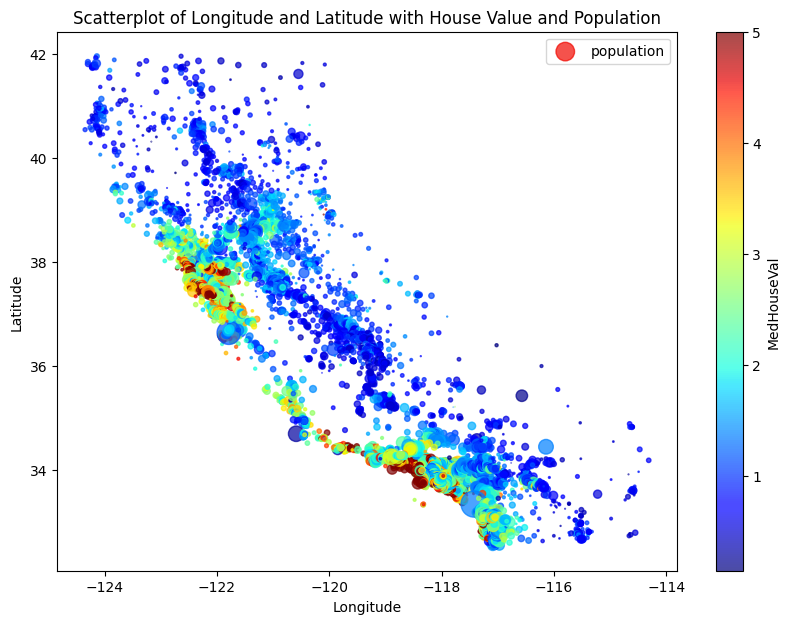

In [412]:
combined_df.plot(
    kind="scatter", 
    x="Longitude",
    y="Latitude", 
    c="MedHouseVal", 
    cmap="jet", 
    colorbar=True, 
    legend=True, 
    sharex=False, 
    figsize=(10,7), 
    s=data['Population']/100, 
    label="population", 
    alpha=0.7)
plt.title("Scatterplot of Longitude and Latitude with House Value and Population")

In [424]:
# plt.figure(figsize=(10, 7))
# scatter = sns.scatterplot(
#     x="Longitude", 
#     y="Latitude", 
#     hue="MedHouseVal",  
#     size="Population",  
#     sizes=(20, 200),    
#     alpha=0.7,          
#     palette="cool",      
#     data=combined_df,          
#     legend=True         
# )

# plt.colorbar(scatter.collections[0], label='MedHouseVal')

# plt.title("Scatterplot of Longitude and Latitude with House Value and Population")
# plt.legend(title="Population")

## Bivariate analysis

- Positive linear relationship between MedHouseVal and MedInc. This makes intuitive sense, as areas with higher income often correlate with higher house values
- There is a slight positive trend where newer houses (HouseAge closer to 0) might have lower house values, and older houses seem to show a slight increase in house values. However, the scatter is quite dense, and the trend isn’t very strong
- Almost no relationship for the rest of the variables

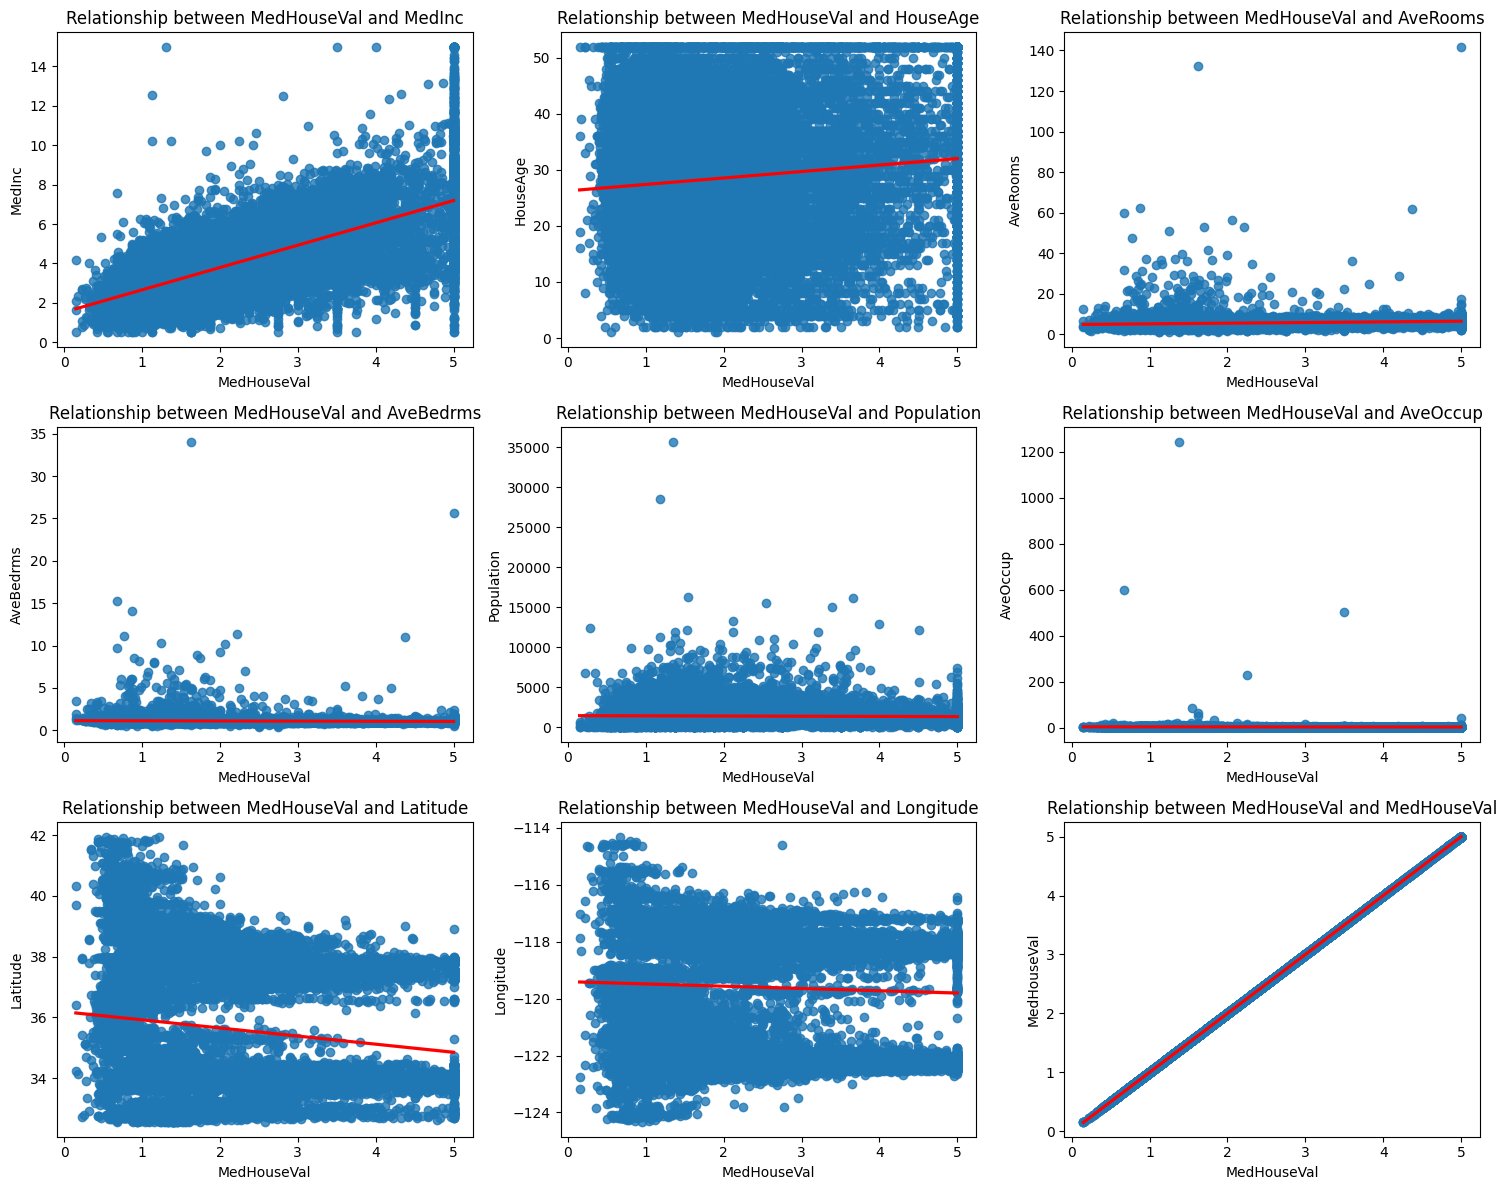

In [348]:
fix, ax = plt.subplots(3, 3, figsize=(15, 12))

for i, col in enumerate(combined_df.columns):
    # sns.scatterplot(data=combined_df, x="MedHouseVal", y=col, ax=ax[i//3, i%3])
    sns.regplot(data=combined_df, x="MedHouseVal", y=col, ax=ax[i//3, i%3], scatter=True, line_kws={"color":"red"})
    ax[i//3, i%3].set_title(f"Relationship between MedHouseVal and {col}")

plt.tight_layout()

#### Correlation

- Strong +ve correlation between MedInc and MedHouseVal
- Weak +ve correlation between HouseAge, AveRooms and MedHouseVal
- The rest of the correlations are very weak with MedHouseVal

<u>Relationships of interest (other)</u>
- AveRooms and MedInc have a weak +ve correlation
- AveBedrms and AveRooms have a strong +ve correlation
- Population and HouseAge has a weak -ve correlation

<Axes: >

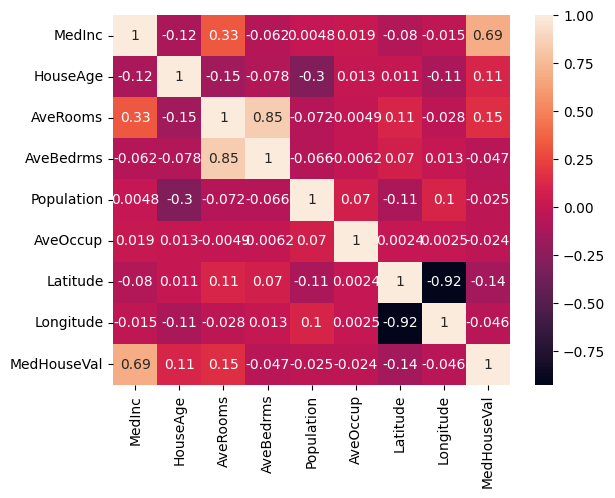

In [349]:
sns.heatmap(combined_df.corr(), annot=True)

#### AveRooms vs MedInc

- +ve correlation

<Axes: xlabel='AveRooms', ylabel='MedInc'>

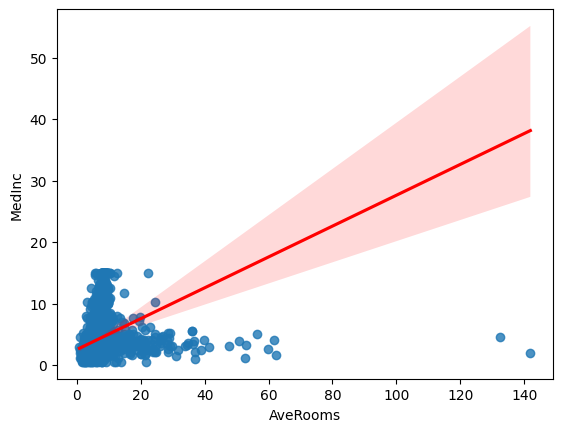

In [350]:
sns.regplot(x='AveRooms', y='MedInc', data=combined_df, scatter=True, line_kws={"color":"red"})

#### AveRooms vs AveBedrms

- A strong positive linear relationship between number or rooms and number of bedrooms

<Axes: xlabel='AveRooms', ylabel='AveBedrms'>

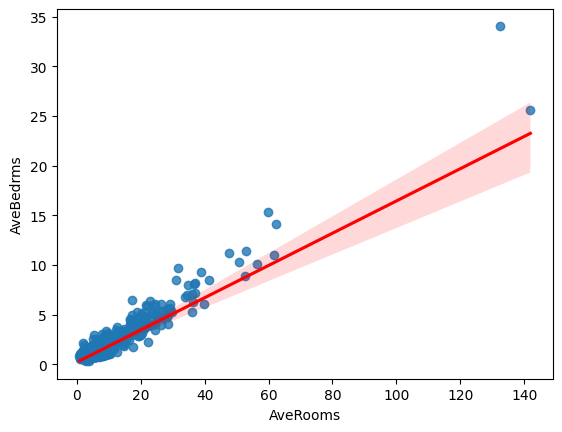

In [351]:
sns.regplot(x='AveRooms', y='AveBedrms', data=combined_df, scatter=True, line_kws={"color":"red"})

#### Population vs HouseAge
- Negative linear relationship

<Axes: xlabel='Population', ylabel='HouseAge'>

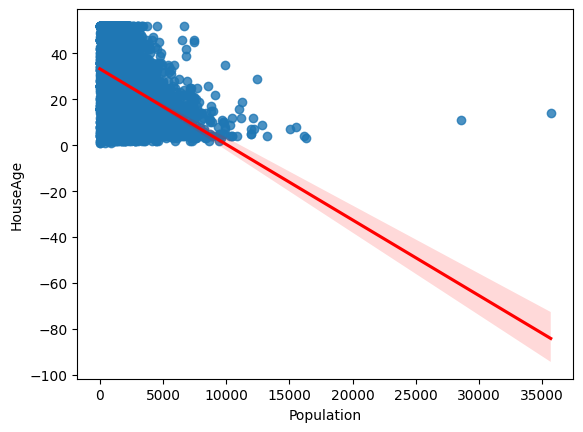

In [352]:
sns.regplot(x='Population', y='HouseAge', data=combined_df, scatter=True, line_kws={"color":"red"})

#### AveRooms vs Population
- The houses with the most rooms have a block group population of 0, might it mean that they're hotels?
- There are 2 houses with very high block group population, they might be high rise properties
- Most of the expensive houses have less than 20 rooms
- The 2 densely populated houses are not very expensive
- The 2 houses with a lot of rooms; one is expensive the other is cheaper (high end and cheaper hotel?)

<Axes: xlabel='AveRooms', ylabel='Population'>

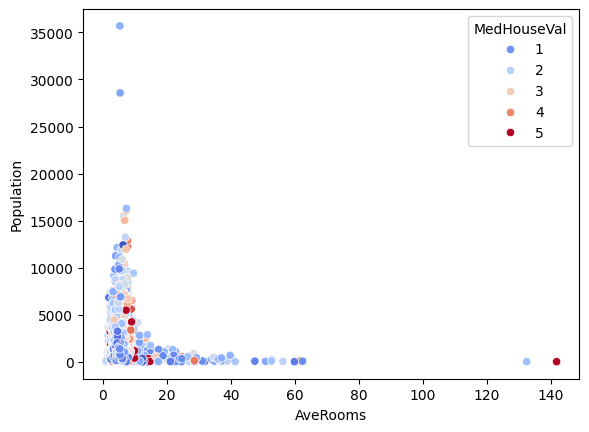

In [353]:
sns.scatterplot(x='AveRooms', y='Population', data=combined_df, hue='MedHouseVal', palette='coolwarm')

In [354]:
combined_df[combined_df['AveRooms'] > 100] # not certain what these houses are

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
1914,1.875,33.0,141.909091,25.636364,30.0,2.727273,38.91,-120.10,5.00001
1979,4.625,34.0,132.533333,34.066667,36.0,2.400000,38.80,-120.08,1.62500


- Best features appear to be MedInc, Latitude and Longitude
- HouseAge might also be a good feature

# Validation framework

In [355]:
n = len(data)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val + n_test)

n_val, n_test, n_train

(4128, 4128, 12384)

In [356]:
# add randomness to data split
idx = np.arange(n)

np.random.seed(2)
np.random.shuffle(idx)

In [357]:
df_train = data.iloc[idx[:n_train]]
df_val = data.iloc[idx[n_train:n_train + n_val]]
df_test = data.iloc[idx[n_train + n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

len(df_train), len(df_val), len(df_test)

(12384, 4128, 4128)

In [358]:
df_target_train = target.iloc[idx[:n_train]]
df_target_val = target.iloc[idx[n_train:n_train + n_val]]
df_target_test = target.iloc[idx[n_train + n_val:]]

In [359]:
# normalizing the data performs better
y_train = np.log1p(df_target_train).values
y_val = np.log1p(df_target_val).values
y_test = np.log1p(df_target_test).values

# y_train =df_target_train
# y_val = df_target_val.values
# y_test = df_target_test.values

y_train.shape, y_val.shape, y_test.shape

((12384,), (4128,), (4128,))

In [360]:
df_train.shape, df_val.shape, df_test.shape

((12384, 8), (4128, 8), (4128, 8))

# Linear regression model

## Create model

In [361]:
def train_linear_regression(X, y):
    # add bias/baseline term to the features matrix
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X) # Gram matrix
    XTX_inv = np.linalg.inv(XTX)

    XTX.dot(XTX_inv).round(1) # Should be an identity matrix

    w_full = XTX_inv.dot(X.T).dot(y) # linear regression normal equation
    return w_full[0], w_full[1:]

## Prepare data

In [379]:
df_train.columns[:-2]

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup'],
      dtype='object')

In [380]:
def prepare_X(df):
    df = df.copy()
    # normalize all data except coordinates -> didn't help much (wonder if there's a better way to handle coordinates)
    base = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']

    for col in base:
        df[col] = np.log1p(df[col])

    return df

## Model training

In [381]:
X_train = prepare_X(df_train)

w0, w = train_linear_regression(X_train, y_train)
w0, w # we can use the weights to make predictions

(np.float64(-12.386522903978506),
 array([ 0.71564914,  0.06181116, -0.27487666,  0.65916301,  0.00788727,
        -0.33062902, -0.15195366, -0.15037569]))

In [382]:
y_pred = w0 + X_train.dot(w)
y_pred

0        1.266451
1        0.802132
2        0.723857
3        1.331583
4        1.377601
           ...   
12379    1.080654
12380    1.167217
12381    1.488658
12382    1.346236
12383    1.389036
Length: 12384, dtype: float64

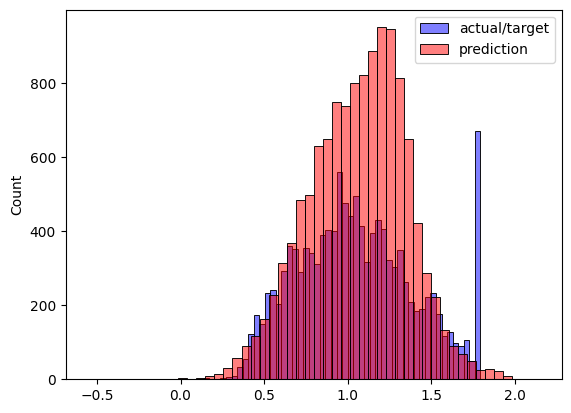

In [383]:
# check how the predictions compare to the actual values
sns.histplot(y_train, color='blue', alpha=0.5, bins=50, label='actual/target')
sns.histplot(y_pred, color='red', alpha=0.5, bins=50, label='prediction')

plt.legend()

## RMSE

In [384]:
def rmse(y, y_pred):
    error = y - y_pred
    se = (error ** 2)
    mse = se.mean()
    return np.sqrt(mse)

In [385]:
rmse(y_train, y_pred)

np.float64(0.20202578706475185)

# Model validation

In [386]:
X_val = prepare_X(df_val)

# use the trained weights to make predictions
y_pred = w0 + X_val.dot(w) 
rmse(y_val, y_pred)

np.float64(0.20017078267607782)

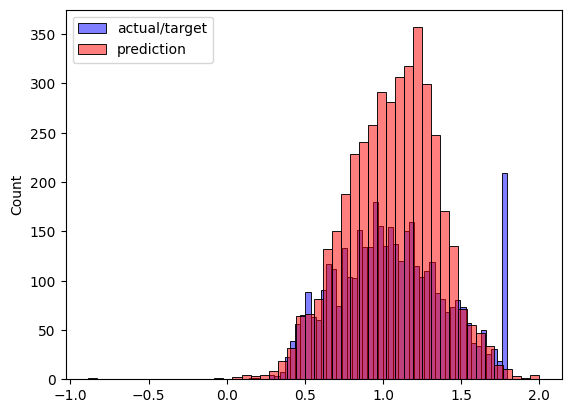

In [387]:
# check how the predictions compare to the actual values
sns.histplot(y_val, color='blue', alpha=0.5, bins=50, label='actual/target')
sns.histplot(y_pred, color='red', alpha=0.5, bins=50, label='prediction')

plt.legend()

## Regularize model

- Regularization has no impact for this model, and adding all features produces better results

In [388]:
def train_linear_regression_regularized(X, y, r=0.001):
    # add bias/baseline term to the features matrix
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X) # Gram matrix
    XTX = XTX + (np.eye(XTX.shape[0]) * r) # regularization
    XTX_inv = np.linalg.inv(XTX)

    XTX.dot(XTX_inv).round(1) # Should be an identity matrix

    w_full = XTX_inv.dot(X.T).dot(y) # linear regression normal equation
    return w_full[0], w_full[1:]

## Tune the model

In [389]:
best_r = None
best_rmse = np.inf

for r in [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_regularized(X_train, y_train, r=r)
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_val, y_pred)

    if score < best_rmse:
        best_r = r
        best_rmse = score

    print(r, w0, rmse(y_val, y_pred))

best_r, best_rmse

0.0 -12.386522903978506 0.20017078267607782
1e-05 -12.386338044689547 0.2001707568438263
0.0001 -12.384674559720931 0.20017052479704323
0.001 -12.368064295815302 0.20016824819094442
0.01 -12.204384156970034 0.20014974562132423
0.1 -10.77835412754174 0.20029059574382815
1 -4.97770930790467 0.20635228258031257
5 -1.4805611463900092 0.21404235128763496
10 -0.795972700496336 0.21599133723881722


(0.01, np.float64(0.20014974562132423))

In [390]:
# retrain model
X_train = prepare_X(df_train)
w0, w = train_linear_regression_regularized(X_train, y_train, r=best_r)
print(w0, w)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w) 
rmse(y_val, y_pred)

-12.204384156970034 [ 0.71790161  0.06223536 -0.27831447  0.65935058  0.00780408 -0.33117299
 -0.15020053 -0.14835234]


np.float64(0.20014974562132423)

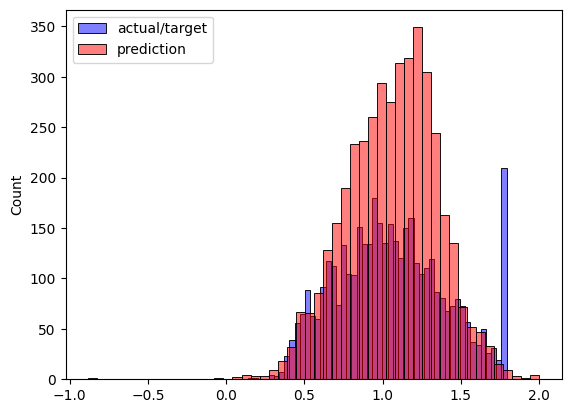

In [391]:
# check how the predictions compare to the actual values
sns.histplot(y_val, color='blue', alpha=0.5, bins=50, label='actual/target')
sns.histplot(y_pred, color='red', alpha=0.5, bins=50, label='prediction')

plt.legend()

# Using the model

In [392]:
X_test = prepare_X(df_test)

# use the trained weights to make predictions
y_pred = w0 + X_test.dot(w) 
score = rmse(y_test, y_pred) 
print(f"RMSE: {score}")

RMSE: 0.21091055362624392


In [393]:
def make_prediction(idx):
    house = df_test.iloc[idx].to_dict()
    house_df = pd.DataFrame([house])
    
    X_house = prepare_X(house_df)

    house_pred = w0 + X_house.dot(w) 
    house_pred = house_pred[0]

    print(f"Prediction: {np.expm1(house_pred)} - Actual: {np.expm1(y_test[idx])}")

make_prediction(500)

Prediction: 1.7828548479654391 - Actual: 1.25


[scikit-learn tutorial](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html)

Model performs better than the tutorial

In [400]:
from sklearn.metrics import r2_score, root_mean_squared_error

r2_score(y_test, y_pred)

0.6498860062948975

In [403]:
root_mean_squared_error(y_test, y_pred)

np.float64(0.21091055362624392)